### Dataset
CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classe

### Goal
bulding a classification pipeline by appling a dimension reduction model and then applying KNN. We tune hyperparameters through GridSearchCV.

In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from six.moves import cPickle as pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

                               
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs=[]
    ys=[]
    for b in range(1,6):
        filename = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        with open(filename, 'rb') as f:
            datadict = pickle.load(f,encoding='latin1')
            X = datadict['data']
            Y = datadict['labels']
            #X is of shape (10000, 3072) and Y is a list
            """X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)"""
            xs.append(X)
            ys.append(Y)
    X_tr = np.concatenate(xs)
    Y_tr = np.concatenate(ys)
    del X, Y
    filename = os.path.join(ROOT, 'test_batch')
    #loading test data 
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
        X_te = datadict['data']
        Y_te = datadict['labels']
        """X_te = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int")
        Y_te = np.array(Y)"""
        
    
    return X_tr, Y_tr, X_te, Y_te

In [3]:
cifar10_dir = 'cifar-10-batches-py'
X_tr, y_tr, X_te, y_te = load_CIFAR10(cifar10_dir)

In [4]:
print("X_train shape is",X_tr.shape)
print("X_test shape is",X_te.shape)
print("y_train shape is",y_tr.shape)
print("ytest shape is",y_tr.shape)
print("number of calsses is",np.unique(y_tr))

X_train shape is (50000, 3072)
X_test shape is (10000, 3072)
y_train shape is (50000,)
ytest shape is (50000,)
number of calsses is [0 1 2 3 4 5 6 7 8 9]


In [5]:
X = X_tr[100].reshape(3, 32, 32).transpose(1,2,0).astype("float")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


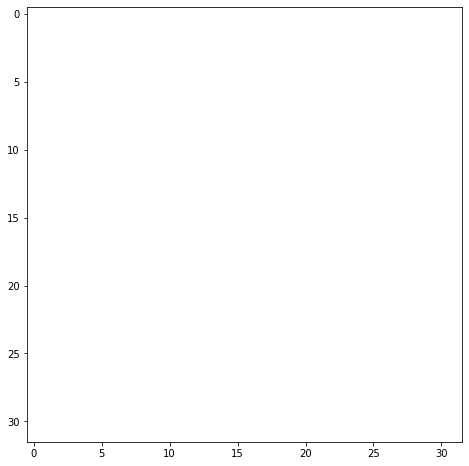

In [6]:
plt.imshow(X)

In [7]:
sc=StandardScaler()
pca=PCA()
lda=LinearDiscriminantAnalysis()
knn=KNeighborsClassifier()
pipe=Pipeline(steps=[('sc',sc),('pca', pca), ('lda', lda),('knn',knn)])


In [8]:
# Use a nearest neighbor classifier to evaluate the methods
# 10, 15, 20, 50, 100
params_grid =[{
    "knn__n_neighbors": [3,5],
    "pca__n_components":[2,3],
    "lda":[None]
},
{
    "knn__n_neighbors": [3,5],
    "lda__n_components":[2,3],
    "pca":[None]
}    
]

grid_search = GridSearchCV(pipe, param_grid = params_grid, cv=5,
                               scoring='neg_mean_squared_error')
grid_search.fit(X_tr,y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA()),
                                       ('lda', LinearDiscriminantAnalysis()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [3, 5], 'lda': [None],
                          'pca__n_components': [2, 3]},
                         {'knn__n_neighbors': [3, 5],
                          'lda__n_components': [2, 3], 'pca': [None]}],
             scoring='neg_mean_squared_error')

In [9]:
print(grid_search.best_params_)
model=grid_search.best_estimator_
print(model)

{'knn__n_neighbors': 5, 'lda__n_components': 3, 'pca': None}
Pipeline(steps=[('sc', StandardScaler()), ('pca', None),
                ('lda', LinearDiscriminantAnalysis(n_components=3)),
                ('knn', KNeighborsClassifier())])


In [10]:
Y_pred=model.predict(X_te)

In [11]:
final_mse = mean_squared_error(y_te,Y_pred )
final_rmse = np.sqrt(final_mse)
accuracy_score=accuracy_score(y_te,Y_pred )


In [12]:
print("final_rmse", final_rmse)
print("accuracy_score is", accuracy_score)

final_rmse 3.926983575213933
accuracy_score is 0.2595


In [13]:
pickle.dump(model, open('KNN', 'wb'))